In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('/Users/johnsmith/Desktop/Senior Design Stuff/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix (1).txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('/Users/johnsmith/Desktop/Senior Design Stuff/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('/Users/johnsmith/Desktop/Senior Design Stuff/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


In [3]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))



Number of common samples: 864


In [4]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df[brca_df.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (929, 60663)
hrd_df_common: (864, 5)
brca_df_common: (864, 33)


In [5]:
rnaseq_df_common.head()

,Case ID,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
2,TCGA-E9-A1RH,TCGA-E9-A1RH-11A,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599


In [6]:
#merge metadata

metadata = pd.merge(hrd_df_common, brca_df_common, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(864, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,0.041857,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,0.120368,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,0.604671,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,0.040404,0,0,0,0,0,LumA,0


In [7]:

# Start with the original dataframe
metadata_filtered = metadata.copy()

# Drop rows where event.BRCA1 is '1'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
metadata_filtered = metadata_filtered[metadata_filtered['event.PALB2'] != '2']

print (metadata_filtered.shape)
print(metadata_filtered.columns)
metadata_filtered.head()

metadata = metadata_filtered
metadata['HRD_status'] = ['HRD' if x >= 42 else 'HR' for x in metadata['HRD-sum']]
metadata['HRD_status'].value_counts()

(857, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


HRD_status
HR     652
HRD    205
Name: count, dtype: int64

In [8]:
# drop rna samples not in metadata
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samp = set(rnaseq_df['Case ID'])
metadata_samp = set(metadata.index)

# Find the intersection of all sample IDs
common_samp = rnaseq_samp.intersection(metadata_samp)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samp))



Number of common samples: 857


In [9]:
# Drop samples that are not common between metadata and rnaseq data
rnaseq_df_filtered = rnaseq_df_common[rnaseq_df_common['Case ID'].isin(common_samp)]
rnaseq_df_filtered.shape

(921, 60663)

In [10]:
rnaseq_df_filtered.head()


,Case ID,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
2,TCGA-E9-A1RH,TCGA-E9-A1RH-11A,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599


In [11]:

rnaseq_df_filtered = rnaseq_df_filtered.set_index('Case ID').drop(['Sample ID', 'Sample Type'], axis=1)
rnaseq_df_filtered.head()

,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,ENSG00000001036.14|FUCA2|protein_coding,ENSG00000001084.13|GCLC|protein_coding,ENSG00000001167.14|NFYA|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E9-A1RH,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,8.4782,5.9064,19.4040,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
TCGA-C8-A26W,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,30.4546,4.3523,17.3752,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
TCGA-E9-A1RH,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,13.6652,6.0568,5.9571,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
TCGA-AO-A0JJ,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,16.7889,3.6701,9.3094,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
TCGA-BH-A0HO,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,12.5473,5.9260,10.1433,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599


In [12]:
rnaseq_df_filtered = rnaseq_df_filtered.round().astype(int)
rnaseq_df_filtered = rnaseq_df_filtered[~rnaseq_df_filtered.index.duplicated(keep='first')]

In [13]:
print(f"Shape of rnaseq_df_filtered: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata: {metadata.shape}")

Shape of rnaseq_df_filtered: (857, 60660)
Shape of metadata: (857, 38)


In [14]:
print("rnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])  # Print first 5 index values
print("\nmetadata index:")
print(metadata.index[:5])  # Print first 5 index values

# Check for any mismatches
mismatched = set(rnaseq_df_filtered.index) ^ set(metadata.index)
print(f"\nNumber of mismatched indices: {len(mismatched)}")
if len(mismatched) > 0:
    print("Sample of mismatched indices:")
    print(list(mismatched)[:5])  # Print up to 5 mismatched indices

rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object', name='Case ID')

metadata index:
Index(['TCGA-A1-A0SB', 'TCGA-A1-A0SD', 'TCGA-A1-A0SE', 'TCGA-A1-A0SF',
       'TCGA-A1-A0SG'],
      dtype='object', name='sample')

Number of mismatched indices: 0


In [15]:
# Find common indices
common_indices = rnaseq_df_filtered.index.intersection(metadata.index)

# Filter both DataFrames to keep only common indices
rnaseq_df_filtered = rnaseq_df_filtered.loc[common_indices]
metadata = metadata.loc[common_indices]

# Verify the shapes and indices again
print(f"Shape of rnaseq_df_filtered after alignment: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata after alignment: {metadata.shape}")

print("\nrnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])
print("\nmetadata index:")
print(metadata.index[:5])

Shape of rnaseq_df_filtered after alignment: (857, 60660)
Shape of metadata after alignment: (857, 38)

rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')

metadata index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')


In [16]:

# Step 2: Create the DESeqDataSet object
dds = DeseqDataSet(
    counts=rnaseq_df_filtered,
    metadata=metadata,
    design_factors="HRD_status",
)


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_16349/2632761707.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [17]:

# Step 3: Run the differential expression analysis
dds.deseq2()


Fitting size factors...
... done in 1.19 seconds.

Fitting dispersions...
... done in 9.72 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 14.36 seconds.

Fitting LFCs...
... done in 7.40 seconds.

Calculating cook's distance...
... done in 3.73 seconds.

Replacing 1342 outlier genes.

Fitting dispersions...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 0.42 seconds.

Fitting LFCs...
... done in 0.32 seconds.



In [18]:

# Step 4: Get the results
stat_res = DeseqStats(dds)
stat_res.summary()

# Get results table
results = stat_res.results_df

# Display the top differentially expressed genes
print(results.sort_values('padj').head(10))


Running Wald tests...
... done in 2.76 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
                                              baseMean  log2FoldChange  \
ENSG00000000003.15|TSPAN6|protein_coding     12.626991        0.081396   
ENSG00000000005.6|TNMD|protein_coding         0.762781        0.105326   
ENSG00000000419.13|DPM1|protein_coding       36.530356        0.370295   
ENSG00000000457.14|SCYL3|protein_coding       4.328499       -0.299204   
ENSG00000000460.17|C1orf112|protein_coding    2.252513        0.549411   
...                                                ...             ...   
ENSG00000288669.1|AC008763.4|protein_coding   0.000000             NaN   
ENSG00000288670.1|AL592295.6|lncRNA           4.378473       -0.088367   
ENSG00000288671.1|AC006486.3|protein_coding   0.000000             NaN   
ENSG00000288674.1|AL391628.1|protein_coding   0.000000             NaN   
ENSG00000288675.1|AP006621.6|protein_coding   0.213027       -0.220757   

                                                lfcS

In [19]:
print(results.head())

                                             baseMean  log2FoldChange  \
ENSG00000000003.15|TSPAN6|protein_coding    12.626991        0.081396   
ENSG00000000005.6|TNMD|protein_coding        0.762781        0.105326   
ENSG00000000419.13|DPM1|protein_coding      36.530356        0.370295   
ENSG00000000457.14|SCYL3|protein_coding      4.328499       -0.299204   
ENSG00000000460.17|C1orf112|protein_coding   2.252513        0.549411   

                                               lfcSE      stat        pvalue  \
ENSG00000000003.15|TSPAN6|protein_coding    0.077879  1.045166  2.959465e-01   
ENSG00000000005.6|TNMD|protein_coding       0.357472  0.294641  7.682678e-01   
ENSG00000000419.13|DPM1|protein_coding      0.045137  8.203779  2.329453e-16   
ENSG00000000457.14|SCYL3|protein_coding     0.059131 -5.060053  4.191391e-07   
ENSG00000000460.17|C1orf112|protein_coding  0.071708  7.661790  1.833590e-14   

                                                    padj  
ENSG00000000003.15|TS

In [64]:
# Sort the DataFrame by padj values
results_sorted = results.sort_values('padj', ascending=True)

num_rows_to_keep = int(len(results) * 0.02)

bottom_2_percent = results_sorted.head(num_rows_to_keep)
print(bottom_2_percent.shape)
bottom_2_percent.head()
bottom_2_percent.to_csv('/Users/johnsmith/Desktop/Senior Design Stuff/Multiscale_HRD_Classifier/data/bottom_2_percent.tsv', sep='\t', index = True)

(1213, 6)


In [65]:
bottom_2_percent.reset_index(inplace=True)

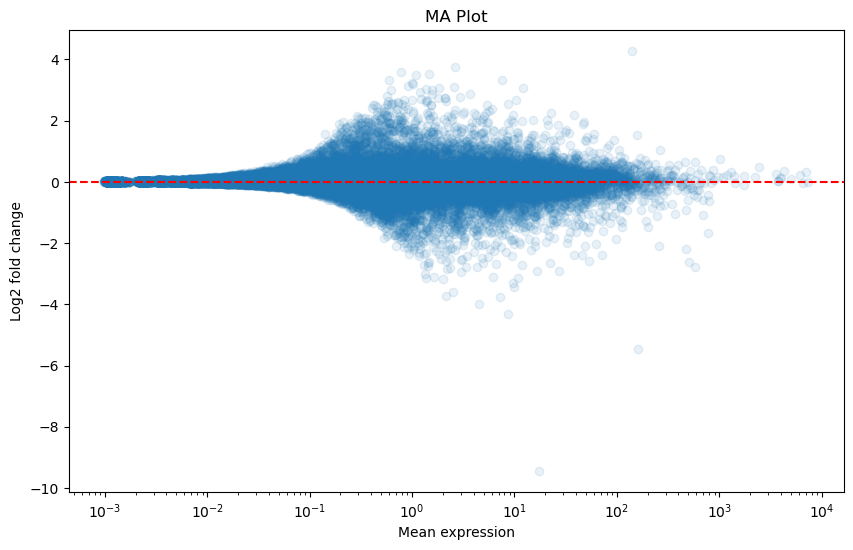

In [21]:

# Step 5: Visualize the results

# MA plot
plt.figure(figsize=(10, 6))
plt.scatter(results['baseMean'], results['log2FoldChange'], alpha=0.1)
plt.xscale('log')
plt.xlabel('Mean expression')
plt.ylabel('Log2 fold change')
plt.title('MA Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


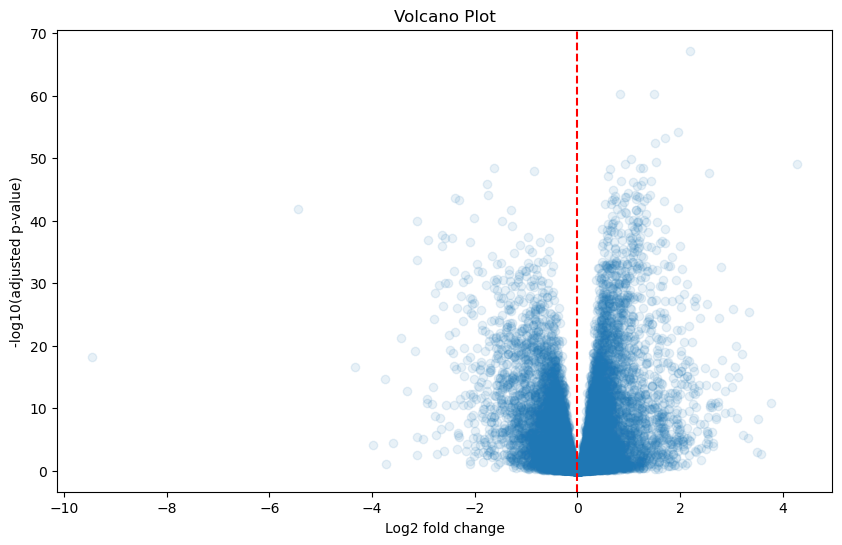

In [22]:

# Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(results['log2FoldChange'], -np.log10(results['padj']), alpha=0.1)
plt.xlabel('Log2 fold change')
plt.ylabel('-log10(adjusted p-value)')
plt.title('Volcano Plot')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


### Running decouplR on Top genes from Deseq

In [30]:
msigdb = dc.get_resource('MSigDB')
msigdb.drop_duplicates(inplace=True)

In [67]:
bottom_2_percent

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000163975.12|MELTF|protein_coding,4.223192,2.197306,0.122265,17.971713,3.245360e-72,6.764303e-68
1,ENSG00000115163.15|CENPA|protein_coding,4.405742,1.489792,0.087457,17.034557,4.551744e-65,4.743600e-61
2,ENSG00000107937.19|GTPBP4|protein_coding,13.539092,0.820738,0.048266,17.004525,7.601871e-65,5.281526e-61
3,ENSG00000136943.11|CTSV|protein_coding,2.170985,1.952020,0.120999,16.132468,1.508699e-58,7.861454e-55
4,ENSG00000140545.15|MFGE8|protein_coding,31.920965,1.701760,0.106421,15.990769,1.481895e-57,6.177426e-54
...,...,...,...,...,...,...,...
1208,ENSG00000152990.14|ADGRA3|protein_coding,4.064661,0.589959,0.066492,8.872677,7.140817e-19,1.231067e-17
1209,ENSG00000133422.14|MORC2|protein_coding,6.271262,0.388311,0.043779,8.869824,7.326180e-19,1.261980e-17
1210,ENSG00000185522.9|LMNTD2|protein_coding,1.187401,-1.446261,0.163087,-8.868061,7.443043e-19,1.281052e-17
1211,ENSG00000187045.19|TMPRSS6|protein_coding,2.285373,-1.874496,0.211414,-8.866466,7.550380e-19,1.298454e-17


In [81]:
deseq_genes = bottom_2_percent['index'].str.split('|').str[1]
gene_list = deseq_genes.to_list()

In [50]:
with open("/Users/johnsmith/Desktop/Senior Design Stuff/gencode.v47.annotation.gff3") as f:
    gff = list(f)

gff = [x for x in gff if not x.startswith('#')]

gff = [x for x in gff if 'gene_id=' in x and 'gene_name=' in x]

gff = list(map(lambda x: (x.split('gene_id=')[1].split(';')[0], x.split('gene_name=')[1].split(';')[0]), gff))

gff = dict(gff)

In [82]:
#mapped_genes = [gff[k] for k in deseq_genes]

In [83]:
ORA_df = dc.get_ora_df(
    df = gene_list,
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

Running ora on df with 1213 targets for 33552 sources with 20000 background features.


In [85]:
ORA_df['-log 10 p-value'] = np.log10(ORA_df['p-value'])*-1
test_pval_filt = ORA_df[ORA_df['p-value'] < 0.05]

test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])
test_pval_filt.tail(10)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,-log 10 p-value
14532,HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_NK_CELL,668,0.296407,1.010445e-84,2.698898e-81,5.652846,1093.298707,ACTL6A;ALYREF;ANLN;APOBEC3B;ARHGAP11A;ASPM;ATA...,83.995487
22289,MODULE_54,262,0.488550,3.952380e-85,1.172979e-81,8.901396,1729.945562,AIF1L;ANLN;ANP32E;APOBEC3B;ARHGAP11A;ASPM;ATAD...,84.403141
19631,MEBARKI_HCC_PROGENITOR_FZD8CRD_UP,541,0.334566,5.790568e-87,1.933326e-83,6.317130,1254.384036,ADGRB2;ANLN;ARHGAP11A;ASPM;ATAD2;AUNIP;AURKA;A...,86.237279
24800,SMID_BREAST_CANCER_BASAL_UP,655,0.303817,2.532798e-87,9.664433e-84,5.803609,1157.213884,ACTG2;AGBL5;AMD1;ANP32E;APOBEC3B;ASPM;ATAD2;AT...,86.596399
14546,HE_LIM_SUN_FETAL_LUNG_C5_PRO_B_CELL,459,0.366013,1.436915e-87,6.396666e-84,6.854065,1370.555416,AARS1;ADGRG1;ANLN;ARHGAP11A;ASPM;ATAD2;AURKA;A...,86.842569
14545,HE_LIM_SUN_FETAL_LUNG_C5_LARGE_PRE_B_CELL,1341,0.215511,1.931304e-88,1.031702e-84,4.355630,879.703506,AARS1;ACTL6A;AFG3L2;AGO2;ALYREF;ANLN;ANP32E;AP...,87.714149
1494,DUTERTRE_ESTRADIOL_RESPONSE_24HR_UP,322,0.450311,2.767351e-90,1.847898e-86,8.309038,1713.446319,ANLN;ARHGAP11A;ASPM;ATAD2;AURKA;AURKB;BIRC5;BL...,89.557936
2259,GOBERT_OLIGODENDROCYTE_DIFFERENTIATION_UP,572,0.340909,1.239594e-95,1.103652e-91,6.514026,1423.515383,AARS1;AKR1E2;ALAD;ANP32E;ARHGAP11A;ASPM;ATAD2;...,94.906721
1700,FISCHER_DREAM_TARGETS,945,0.264550,3.929110e-96,5.247326e-92,5.239801,1151.078294,AARS1;ACTL6A;AMD1;ANKRA2;ANLN;ANP32E;APOBEC3B;...,95.405706
1665,FARMER_BREAST_CANCER_BASAL_VS_LULMINAL,326,0.475460,4.246080e-101,1.134128e-96,8.852380,2045.918679,ABAT;ACADSB;ACTL6A;ALDH6A1;AMD1;ANXA9;APBB2;AR...,100.372012


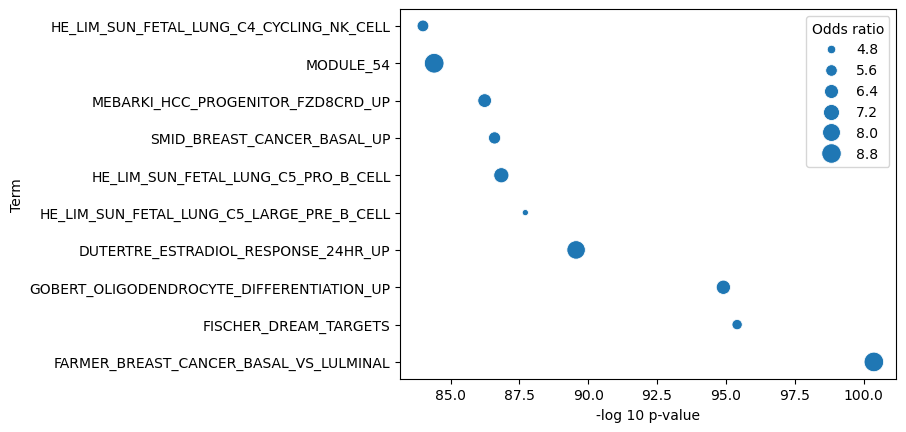

In [86]:
plot = sns.scatterplot(
    data=test_pval_filt.tail(10), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)